# 1-D Toy Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

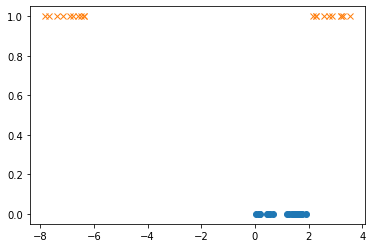

In [2]:
x_0 = np.random.rand(20,1)*2
x_1_1 = np.random.rand(10,1)*2+2
x_1_2 = np.random.rand(10,1)*2-8
x_1 = np.concatenate((x_1_1,x_1_2))

data = np.concatenate((x_0,x_1))
target = np.concatenate((np.zeros((20,1))-1,np.ones((20,1))))

plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.show()

In [3]:
def covariance_function(x1,x2,length,signal_var,noise_var):
    size1 = x1.shape[0]
    size2 = x2.shape[0]
    out = np.zeros((size1,size2))
    for i in range(size1):
        for j in range(size2): 
            xp = x1[i]
            xq = x2[j]
            out[i,j] =signal_var * math.exp(-1/2*(abs(xp-xq)**2)/length)+noise_var*(i==j)
    return out

## Laplace Approximation

In [4]:
def logit_function(x):
    return 1/(1+np.exp(-x))

In [5]:
f = np.zeros_like(target)
K = covariance_function(data,data,1,1,0.1)
K_inv = np.linalg.inv(K)

In [6]:
error = 100
while error>1e-6:
    pi = logit_function(f)
    W = np.zeros((f.shape[0],f.shape[0]))
    temp = (pi*(1-pi)).reshape(-1).tolist()
    np.fill_diagonal(W,temp)
    dp = (target+1)/2 - pi
    cov = np.linalg.inv(K_inv+W)
    f_new = np.matmul(cov,np.matmul(W,f)+dp)
    error = np.sum(np.abs(f_new-f))
    print(error)
    f = f_new
f_hat = f

49.871690300922054
6.542362094790905
0.27936718523646287
0.0006338371198150866
4.2503974506669095e-09


In [7]:
x_star = np.linspace(-9,5,200)
k_star = covariance_function(data,x_star,1,1,0.1)
predicted_mean = np.matmul(np.matmul(k_star.T,K_inv),f_hat)
predicted_var = covariance_function(x_star,x_star,1,1,0.1) - np.matmul(np.matmul(k_star.T,cov),k_star)

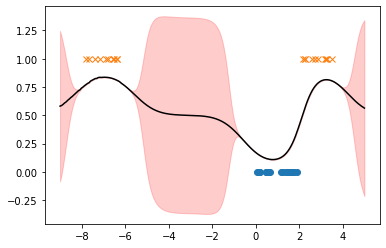

In [8]:
logit_predicted_mean = logit_function(predicted_mean).reshape(-1)
a = predicted_var.diagonal()
a = logit_function(a)
a = np.sqrt(a)
plt.figure()
plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.plot(x_star.reshape(-1),logit_predicted_mean,color='k')
plt.fill_between(x_star.reshape(-1), (logit_predicted_mean-a).clip(-0.5,1.5),(logit_predicted_mean+a).clip(-0.5,1.5),alpha=0.2,color='r')
plt.show()

## Expectation Propagation

In [9]:
f = np.zeros_like(target)
K = covariance_function(data,data,1,1,0)
K_inv = np.linalg.inv(K)

In [10]:
import scipy.stats
import copy
NormalDistribution=scipy.stats.norm(0, 1)

In [11]:
error = 100
mu = np.zeros((data.shape[0],1))
sigma = copy.deepcopy(K)


mu_last = np.zeros((data.shape[0],1))
sigma_last = copy.deepcopy(K)

nu_tilda = np.zeros((data.shape[0],1))
tau_tilda = np.zeros(data.shape[0])

# mu_tilda_new = np.zeros((data.shape[0],1))
# sigma_tilda_new = np.ones(data.shape[0])

# sigma_minus = np.zeros(data.shape[0])
# mu_minus = np.zeros(data.shape[0])

# sigma_hat = np.zeros(data.shape[0])
# mu_hat = np.zeros(data.shape[0])
while error>1e-6:
    for i in range(0,data.shape[0]):
        sigma_i = sigma[i,i]**(0.5)
        tau_minus = sigma_i**(-2) - tau_tilda[i]
        nu_minus = sigma_i**(-2)*mu[i] - nu_tilda[i]
        sigma_minus = tau_minus**(-0.5)
        # print('a',sigma_minus)
        mu_minus = nu_minus / tau_minus
        z_i = (target[i]*mu_minus)/math.sqrt(1+sigma_minus**2)
        mu_hat_i = mu_minus + (NormalDistribution.pdf(z_i)*target[i]*sigma_minus**2) \
                                    /(NormalDistribution.cdf(z_i)*math.sqrt(1+sigma_minus**2))

        sigma_hat_i = sigma_minus**(2) - sigma_minus**(4)*NormalDistribution.pdf(z_i)/ \
                            ((1+sigma_minus**(2))*NormalDistribution.cdf(z_i))* \
                             (z_i+NormalDistribution.pdf(z_i)/NormalDistribution.cdf(z_i))
        sigma_hat_i = sigma_hat_i**(0.5)
        
        dtau_tilda = sigma_hat_i**(-2) - tau_minus - tau_tilda[i]
        tau_tilda[i] = tau_tilda[i] + dtau_tilda
        nu_tilda[i] = sigma_hat_i**(-2)*mu_hat_i - nu_minus
        s_i = copy.deepcopy(sigma[:,i]).reshape(-1,1)
        temp =((dtau_tilda)**(-1)+sigma[i,i])**(-1)*np.matmul(s_i,s_i.T)
        sigma -= temp
        # print(sigma)
        mu = np.dot(sigma,nu_tilda)
        # print(mu)

    S = np.eye(data.shape[0])*tau_tilda
    simga = K - np.dot(K, np.dot(np.linalg.inv((K + np.linalg.inv(S))), K))
    mu = np.dot(sigma, nu_tilda)

    error = np.sum(np.abs(mu_last - mu))+ np.sum(np.abs(sigma-sigma_last))
    sigma_last = sigma
    mu_last = mu
    print(error)
    

539.4928325851357
1.9223414701535637
0.16202510430195474
0.012066312616910185
0.00071311306091007
5.643620066375643e-05
4.207968994224265e-06
2.845008463259191e-07


In [12]:
x_star = np.linspace(-9,5,200)
k_star = covariance_function(data,x_star,1,1,0.1)

In [13]:
S = np.eye(data.shape[0])* tau_tilda
sigma_tilda = np.linalg.inv(S)

predicted_mean = np.dot(np.dot(k_star.T,np.eye(data.shape[0]) - 
                    np.dot(np.linalg.inv(K+sigma_tilda),K)), nu_tilda)
                    
predicted_var = covariance_function(x_star,x_star,1,1,0) - np.matmul(np.matmul(k_star.T,\
                                                            np.linalg.inv(K+sigma_tilda)),k_star)

In [14]:
predicted_prob  = predicted_mean/(np.sqrt(1+predicted_var.diagonal().reshape(-1,1)))
predicted_prob = NormalDistribution.cdf(predicted_prob)

In [15]:

f_star = NormalDistribution.cdf(predicted_mean).reshape(-1)#.diagonal(),
a = predicted_var.diagonal()


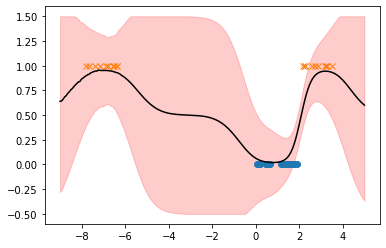

In [16]:
plt.figure()
plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.plot(x_star.reshape(-1),f_star,color='k')
plt.fill_between(x_star.reshape(-1), (f_star-a).clip(-0.5,1.5),(f_star+a).clip(-0.5,1.5),alpha=0.2,color='r')
plt.show()

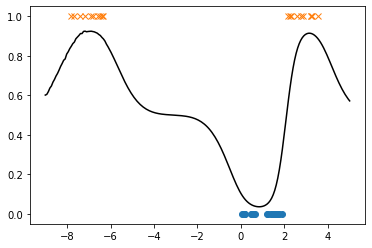

In [17]:
plt.figure()
plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.plot(x_star.reshape(-1),predicted_prob.reshape(-1),color='k')
plt.show()

# Multiclass Toy Problem

In [18]:
x1 = 0.2* np.random.randn(20) + 1
y1 = 0.2*np.random.randn(20) 
x2 = 0.2*np.random.randn(20)  - 0.5
y2 = 0.2*np.random.randn(20) + 0.5
x3 = 0.2*np.random.randn(20) -0.5
y3 = 0.2*np.random.randn(20) -0.5

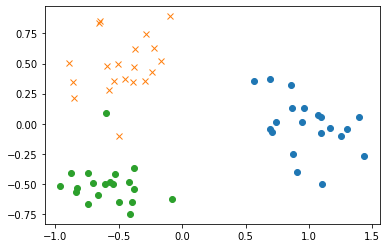

In [19]:
plt.figure()
plt.plot(x1,y1,'o')
plt.plot(x2,y2,'x')
plt.plot(x3,y3,'o')
plt.show()

In [20]:
data_0 = np.concatenate((x1.reshape(-1,1),y1.reshape(-1,1)),axis=1)
label = np.asarray([[1,0,0]])
target_0 = np.repeat(label,data_0.shape[0],axis=0)

data_1 = np.concatenate((x2.reshape(-1,1),y2.reshape(-1,1)),axis=1)
label = np.asarray([[0,1,0]])
target_1 = np.repeat(label,data_1.shape[0],axis=0)

data_2 = np.concatenate((x3.reshape(-1,1),y3.reshape(-1,1)),axis=1)
label = np.asarray([[0,0,1]])
target_2 = np.repeat(label,data_2.shape[0],axis=0)

data = np.concatenate((data_0,data_1,data_2))
target = np.concatenate((target_0,target_1,target_2))

In [21]:
data.shape, target.shape

((60, 2), (60, 3))

In [22]:
def covariance_function(x1,x2,length,signal_var,noise_var):
    size1 = x1.shape[0]
    size2 = x2.shape[0]
    out = np.zeros((size1,size2))
    for i in range(size1):
        for j in range(size2): 
            xp = x1[i]
            xq = x2[j]
            out[i,j] =signal_var * np.exp(-1/2*(np.linalg.norm(xp-xq))/length)+noise_var*(i==j)
    return out


### Laplace Approximation

In [23]:
def softmax(f, N = 60):
    res = []
    for a  in range(N):
        re_f = f[a::N]
        # print(re_f)
        den = np.sum(np.exp(re_f),axis=-1)
        temp = np.exp(re_f)/den.reshape(1,-1)
        res.append(temp)
    return np.concatenate(res,axis=0)

In [24]:
from scipy.linalg import block_diag
import copy

In [25]:
f = np.zeros_like(target)
f = f.T.reshape(-1)
target_exp = target.T.reshape(-1)

K = []
K.append(covariance_function(data,data,1,1,0.1))
K.append(covariance_function(data,data,1,1,0.1))
K.append(covariance_function(data,data,1,1,0.1))

K_tot = block_diag(*K)
f_last = copy.deepcopy(f)
error = 100
N = data.shape[0]

while error>1e-3:
    pi = softmax(f)
    temp_1 = np.eye(data.shape[0])*pi[:,0]
    temp_2 = np.eye(data.shape[0])*pi[:,1]
    temp_3 = np.eye(data.shape[0])*pi[:,2]
    PI = np.concatenate((temp_1,temp_2,temp_3)) # [3N x N]
    pi_exp = pi.T.reshape(-1)

    D = np.eye(3*N)* pi_exp # [900 x 900]
    W = D - np.dot(PI,PI.T)
    f = np.dot(np.linalg.inv((np.linalg.inv(K_tot)+ W)), 
                (np.dot(W,f)+  target_exp - pi_exp))

    error = np.sum(np.abs(f-f_last))
    f_last = f
    print(error)

159.21909086148958
11.337232250130233
0.4362548772617594
0.0013048282885734924
9.475043555307039e-09


In [26]:
f_star = f

In [27]:
x1_star = np.linspace(-1,1.5,30)
x2_star = np.linspace(-1,1.5,30)

xv,yv = np.meshgrid(x1_star,x2_star)
x_star = np.concatenate((xv.reshape(-1,1),yv.reshape(-1,1)), axis=-1)
print(x_star.shape)

Q = []
Q.append(covariance_function(data,x_star,1,1,0.1))
Q.append(covariance_function(data,x_star,1,1,0.1))
Q.append(covariance_function(data,x_star,1,1,0.1))

Q_tot = block_diag(*Q)

pi_star = softmax(f_star)

temp_1 = np.eye(data.shape[0])*pi_star[:,0]
temp_2 = np.eye(data.shape[0])*pi_star[:,1]
temp_3 = np.eye(data.shape[0])*pi_star[:,2]
PI = np.concatenate((temp_1,temp_2,temp_3)) # [900 x 300]
pi_exp = pi_star.T.reshape(-1)

D = np.eye(3*N)* pi_exp # [900 x 900]


predicted_mean = []
for c in range(3):
    k_s = covariance_function(data,x_star,1,1,0.1)
    mu_star_c = np.dot(k_s.T,(target[:,c] - pi_star[:,c]))
    predicted_mean.append(mu_star_c)
W = D - np.dot(PI,PI.T)
predicted_mean = np.concatenate(predicted_mean)

k_ = np.eye(x_star.shape[0])* covariance_function(x_star,x_star,1,1,0.1).diagonal()
k_s = [k_ for _ in range(3)]
k_s = block_diag(*k_s)

K_inv = np.linalg.inv(K_tot)
predicted_cov =  k_s- np.dot(np.dot(np.dot(np.dot(Q_tot.T,K_inv), 
                        np.linalg.inv(K_inv +W)), 
                        K_inv), Q_tot)


(900, 2)


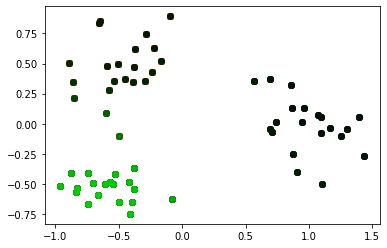

In [28]:
fig, ax = plt.subplots()
plt.plot(x1,y1,'o')
plt.plot(x2,y2,'x')
plt.plot(x3,y3,'o')
for c in range(3):
    predicted_logit = pi_star[:,c]
    for i, a in enumerate(predicted_logit):
        if c == 0:
            plt.plot(data[i,0],data[i,1],'o',color=(0,0,a))
        if c == 1:
            plt.plot(data[i,0],data[i,1],'o',color=(a,0,0))
        if c == 2:
            plt.plot(data[i,0],data[i,1],'o',color=(0,a,0))
plt.show()

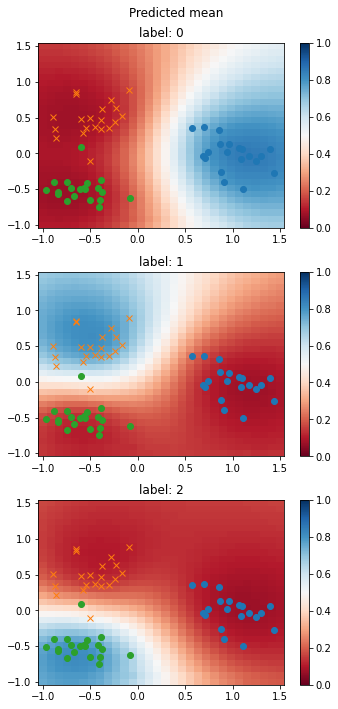

In [42]:
precited_prob = softmax(predicted_mean,N = 900)

fig, ax = plt.subplots(3,1,figsize=(5,10))
plt.suptitle("Predicted mean")
for c in range(3):
    ax[c].set_title("label: {}".format(c))
    ax[c].plot(x1,y1,'o')
    ax[c].plot(x2,y2,'x')
    ax[c].plot(x3,y3,'o')
    predicted_logit = precited_prob[:,c].reshape(30,30)
    a = ax[c].pcolormesh(xv, yv, predicted_logit, cmap='RdBu', vmin=0, vmax=1)
    fig.colorbar(a,ax=ax[c])
plt.tight_layout()
plt.show()


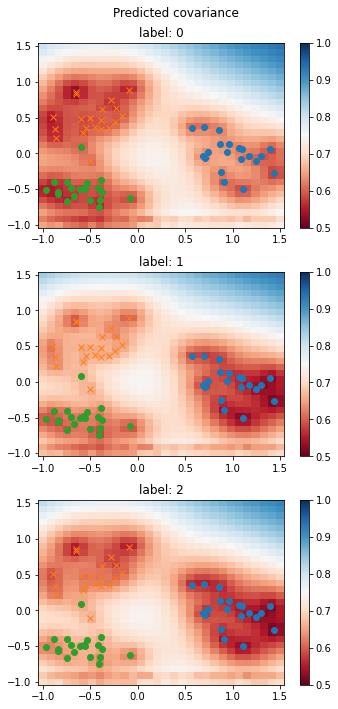

In [45]:
fig, ax = plt.subplots(3,1,figsize=(5,10))
plt.suptitle("Predicted covariance")
for c in range(3):
    ax[c].set_title("label: {}".format(c))
    ax[c].plot(x1,y1,'o')
    ax[c].plot(x2,y2,'x')
    ax[c].plot(x3,y3,'o')
    predicted_var = predicted_cov[c*900:(c+1)*900,c*900:(c+1)*900].diagonal().reshape(30,30)
    a = ax[c].pcolormesh(xv, yv, predicted_var, cmap='RdBu', vmin=0.5, vmax=1)
    fig.colorbar(a,ax=ax[c])
plt.tight_layout()
plt.show()